In [2]:
# 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

import FinanceDataReader as fdr

# debug
import pdb
#pdb.set_trace()

import talib

import seaborn as sns

# 시각화 사용자 설정
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [18]:
# 삼성전자 주가 가져오기
samsung = fdr.DataReader('005930', '2000')
samsung = samsung[['Close']]
samsung

,Close
Date,
2000-01-04,6110
2000-01-05,5580
2000-01-06,5620
2000-01-07,5540
2000-01-10,5770
...,...
2021-01-07,82900
2021-01-08,88800
2021-01-11,91000


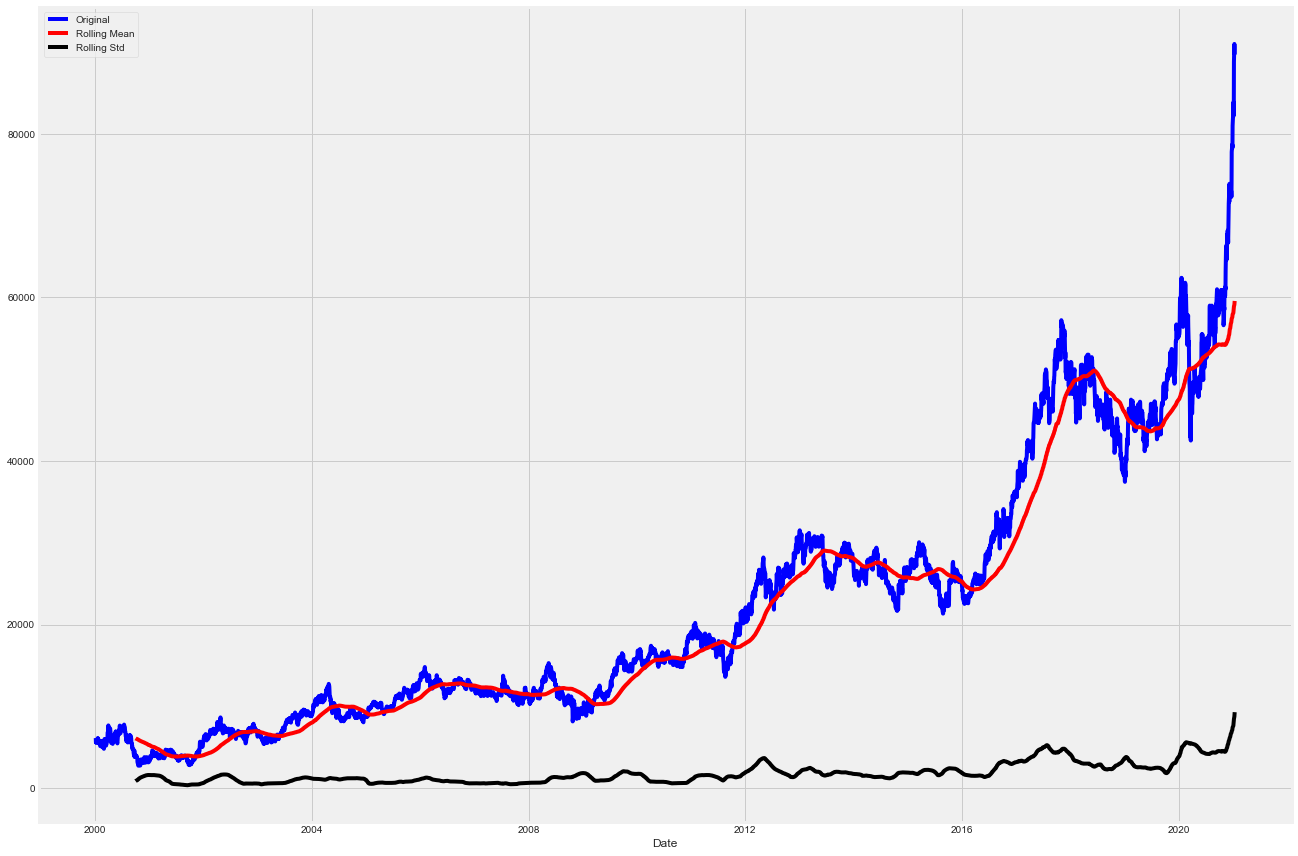

In [19]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20, 15))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()
plot_rolling(samsung, 180)

# prophet 으로 change point 찾아서 해당일에 발생한 이슈 확인하기

원 데이터 ADF Statistic: 2.590
원 데이터 p-value: 0.999
1차 차분 ADF Statistic: -10.796
1차 차분 p-value: 0.000


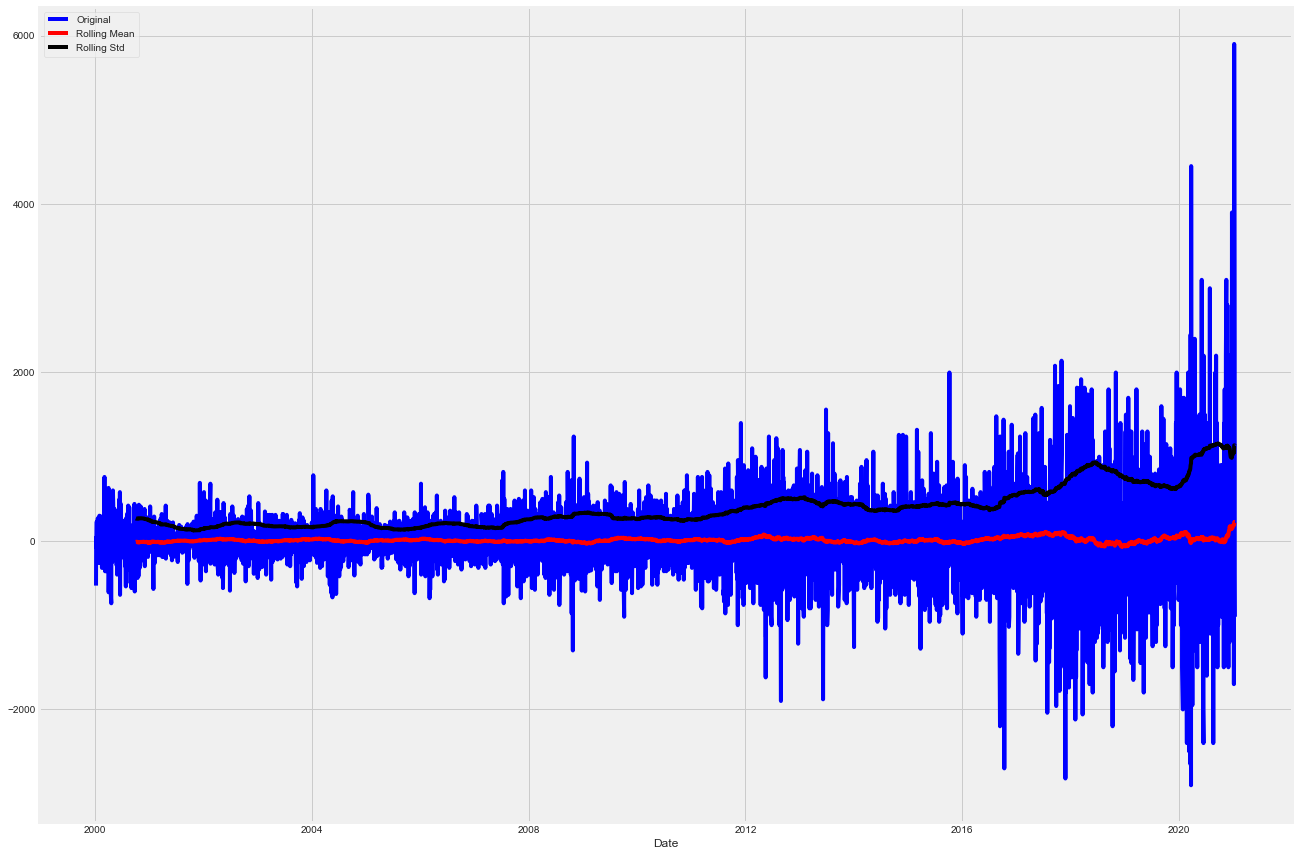

In [20]:
from statsmodels.tsa.stattools import adfuller

def diffADF(data) :
    y = data
    y_1diff = data.diff().dropna()
    result = adfuller(y)
    print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
    print(f'원 데이터 p-value: {result[1]:.3f}')
    result = adfuller(y_1diff)
    print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
    print(f'1차 차분 p-value: {result[1]:.3f}')
    return y_1diff
samsung_diff = diffADF(samsung)
plot_rolling(samsung_diff, 180)

<Figure size 432x288 with 0 Axes>

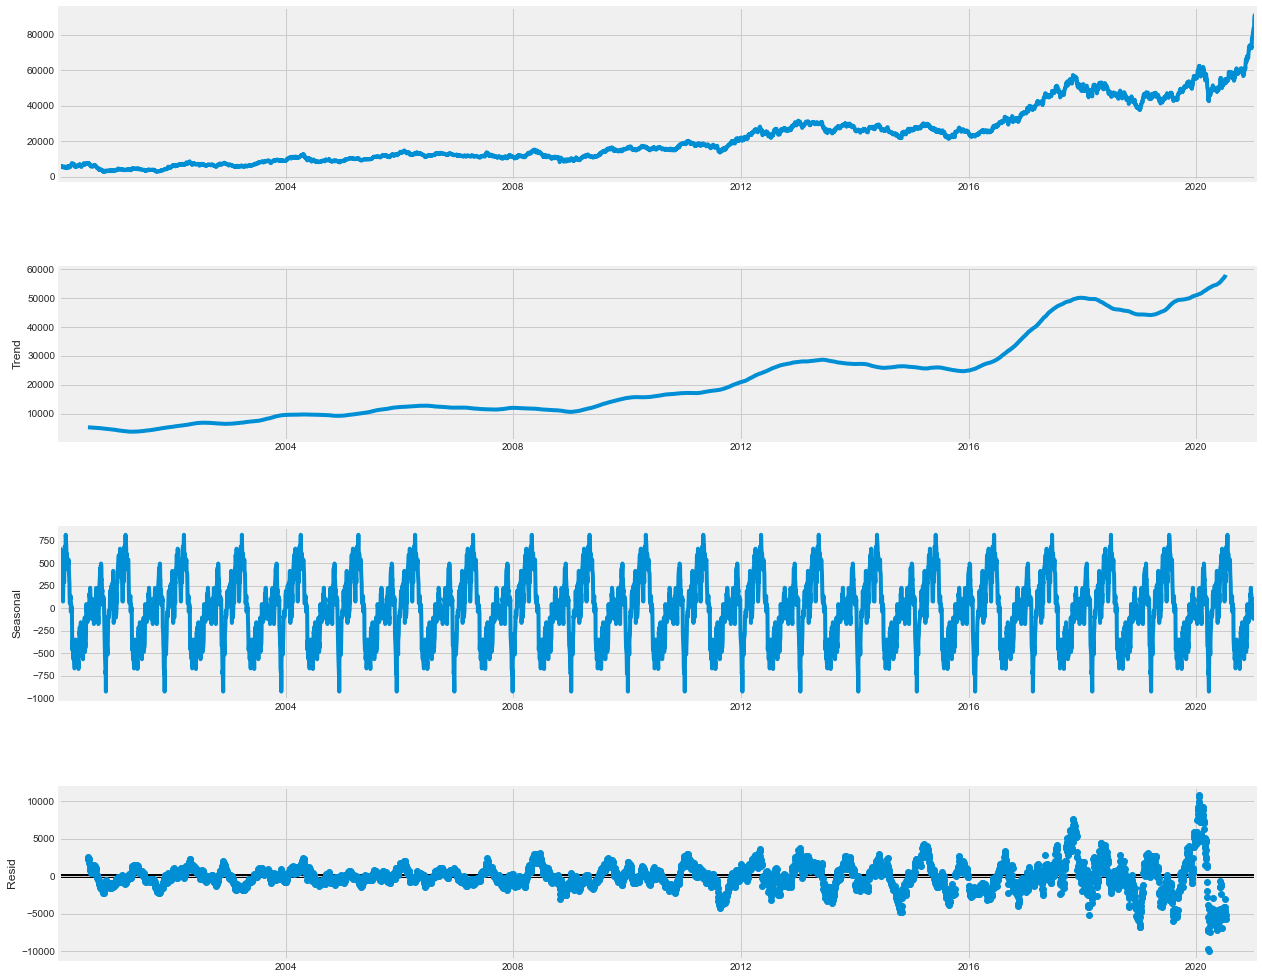

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(samsung, freq=252 )
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(20, 15)

In [7]:
'''
from statsmodels.tsa.arima_model import ARIMA
def my_auto_arima(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df
my_auto_arima(samsung,[3,3,3])
'''

"\nfrom statsmodels.tsa.arima_model import ARIMA\ndef my_auto_arima(data, order,sort = 'AIC'):\n    order_list = []\n    aic_list = []\n    bic_lsit = []\n    for p in range(order[0]):\n        for d in range(order[1]):\n            for q in range(order[2]):\n                model = ARIMA(data, order=(p,d,q))\n                try:\n                    model_fit = model.fit()\n                    c_order = f'p{p} d{d} q{q}'\n                    aic = model_fit.aic\n                    bic = model_fit.bic\n                    order_list.append(c_order)\n                    aic_list.append(aic)\n                    bic_list.append(bic)\n                except:\n                    pass\n    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])\n    result_df.sort_values(sort, inplace=True)\n    return result_df\nmy_auto_arima(samsung,[3,3,3])\n"

In [8]:
from pmdarima.arima import auto_arima

model_arima= auto_arima(samsung_diff,trace=True, error_action='ignore', start_p=1,start_q=1, max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)

model_arima.fit(samsung_diff)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82137.094, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=80861.961, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.80 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=80335.191, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.90 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=7.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=79995.852, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.77 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time

ARIMA(order=(3, 1, 0), scoring_args={}, suppress_warnings=True)

C:\Users\kjy30\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\kjy30\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5191
Model:                 ARIMA(3, 1, 0)   Log Likelihood              -39387.243
Method:                       css-mle   S.D. of innovations            477.547
Date:                Wed, 13 Jan 2021   AIC                          78784.485
Time:                        11:43:44   BIC                          78817.259
Sample:                             1   HQIC                         78795.950
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            16.0894      6.600      2.438      0.015       3.155      29.024
ar.L1.D.Close     0.0455      0.014      3.276      0.001       0.018       0.073
ar.L2.D.Close    -0.0186      0.014     

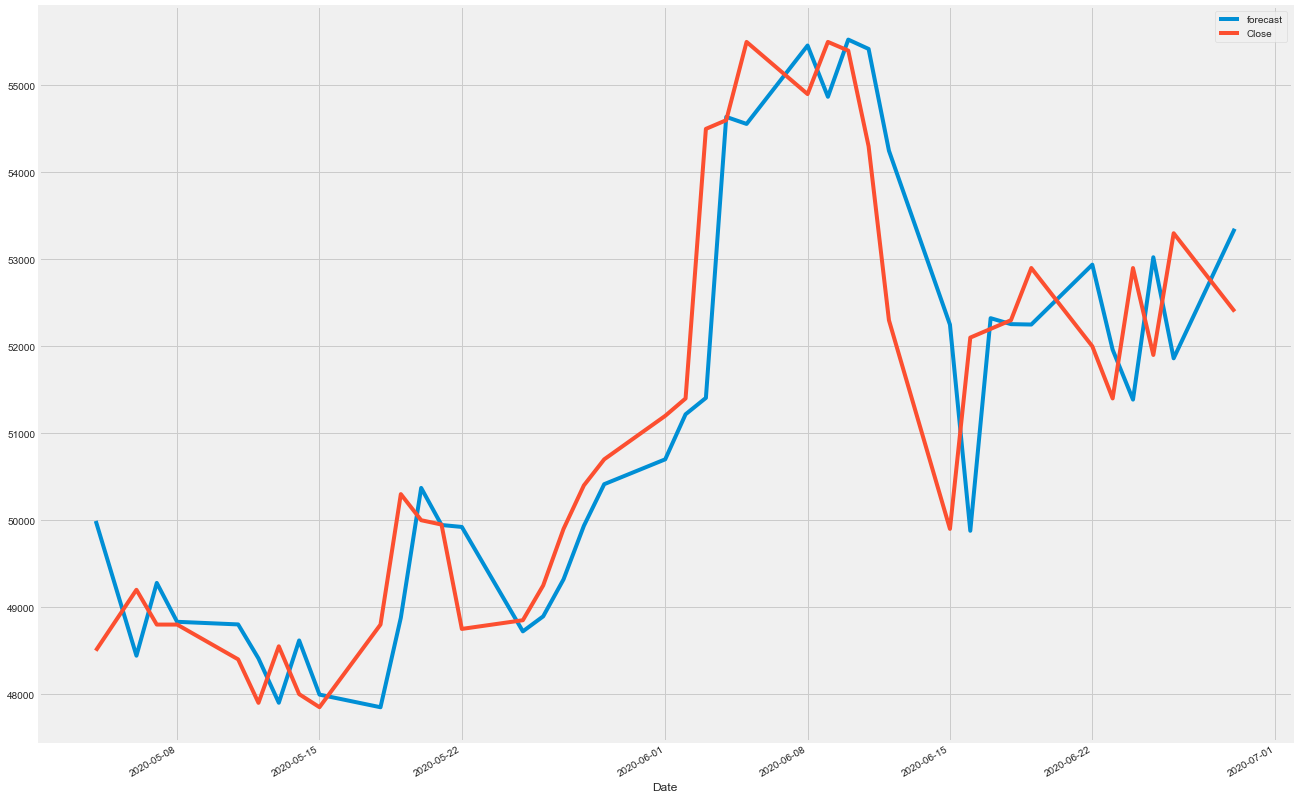

In [22]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(samsung, (3, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

fig = plt.figure(figsize=(20, 15))
ax = fig.subplots()
model_fit.plot_predict(ax=ax, start='2020-05-04', end='2020-06-29')
plt.show()

C:\Users\kjy30\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\kjy30\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


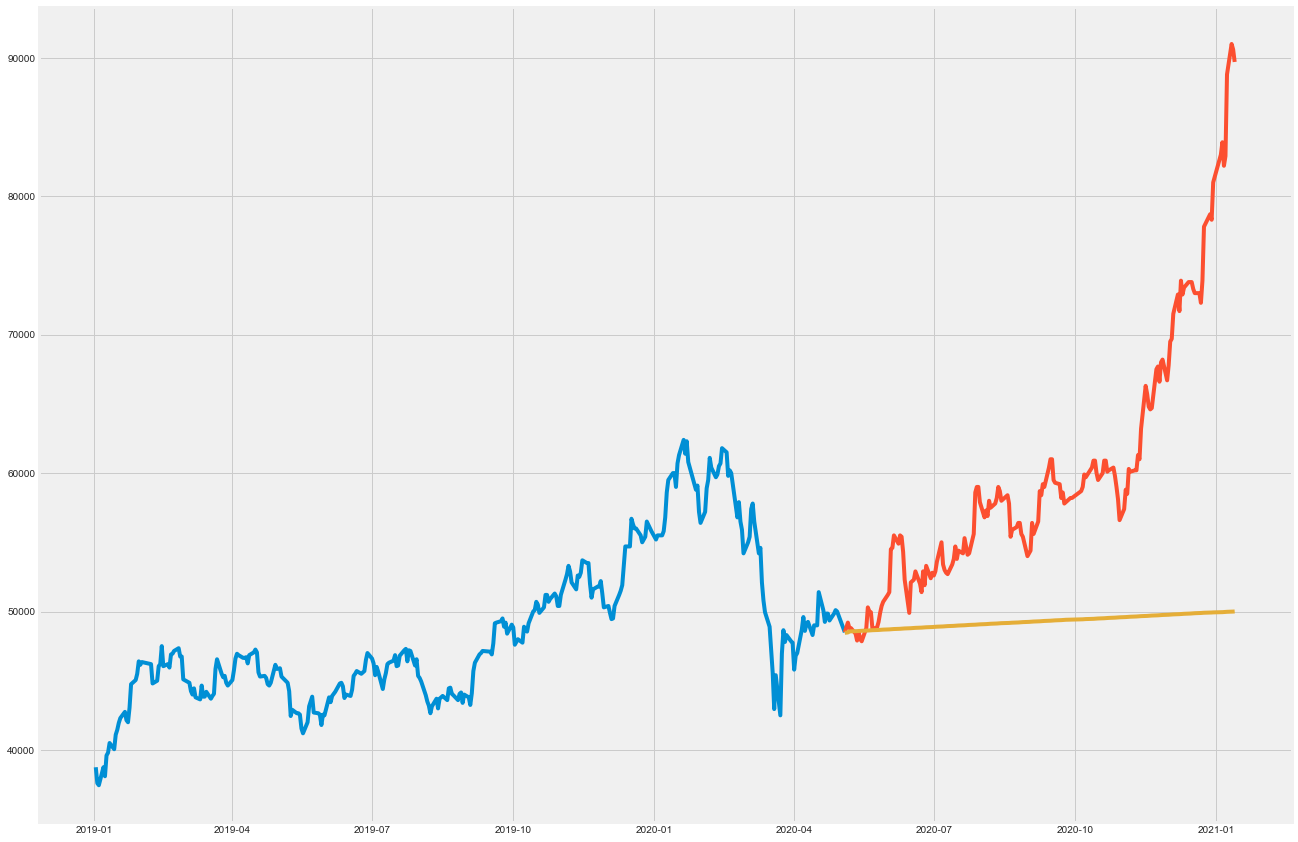

In [23]:
train, test = samsung.loc[:'2020-05-04'], samsung.loc['2020-05-04':]
model = ARIMA(train,(3,1,0))
model_fit = model.fit()
full_forecast = model_fit.forecast(steps=test.shape[0])
forecast = pd.DataFrame(full_forecast[0], index=test.index)
plt.figure(figsize=(20, 15))
plt.plot(train.loc['2018-12-31':])
plt.plot(test)
plt.plot(forecast)

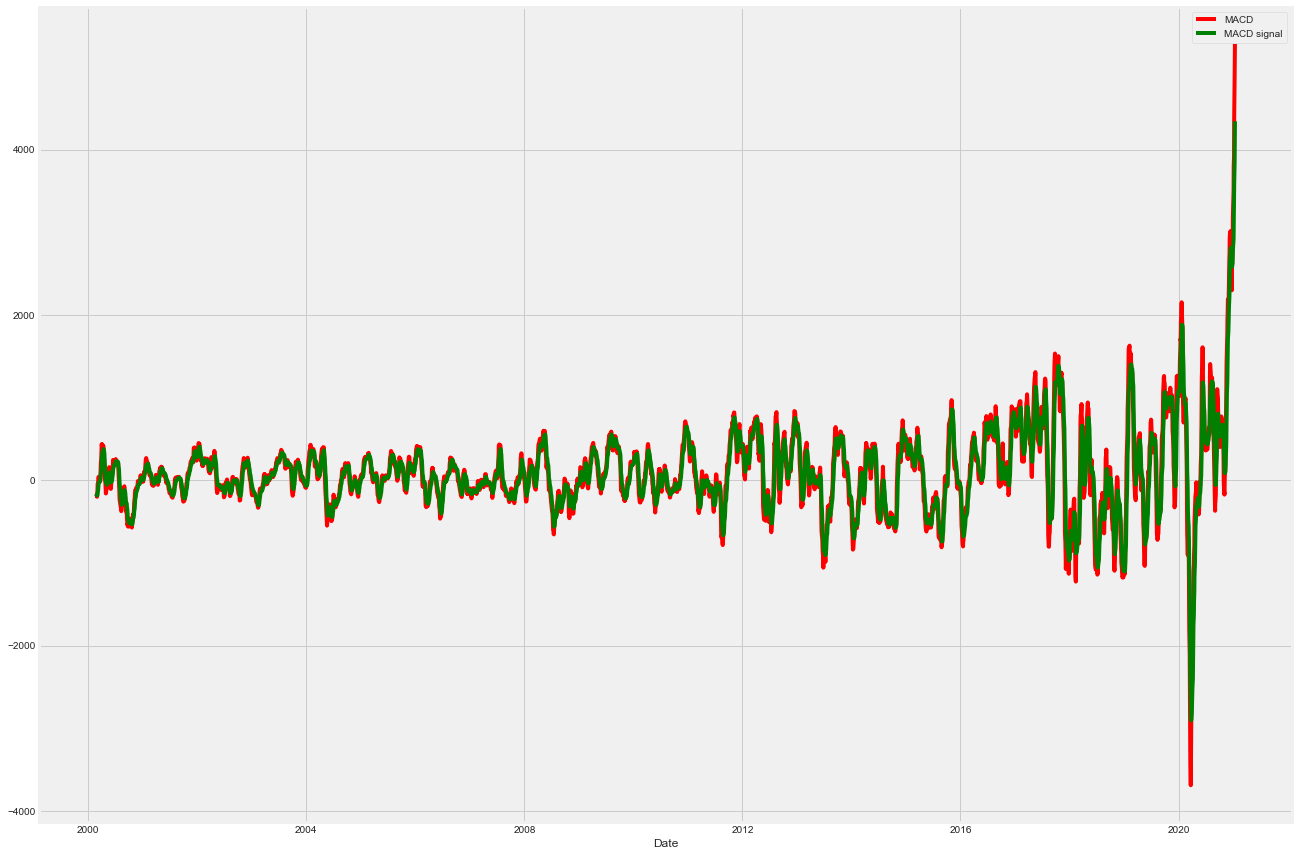

ADF Statistic: -6.021
p-value: 0.000
ADF Statistic: -6.378
p-value: 0.000


In [25]:
# MACD
def plot_macd(data):
    macd, macdsignal, macdhist = talib.MACD(data, fastperiod=12, slowperiod=26, signalperiod=9)
    plt.figure(figsize=(20, 15))
    plt.xlabel('Date')
    plt.plot(macd, color='red', label='MACD')
    plt.plot(macdsignal, color='green', label='MACD signal')
    #macdhist = plt.plot(macdhist, color='pink', label='MACD hist')
    plt.legend(loc='best')
    plt.show()
    return macd, macdsignal
macd, macdsignal = plot_macd(samsung['Close'])

result = adfuller(macd.dropna())
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')
result = adfuller(macdsignal.dropna())
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')

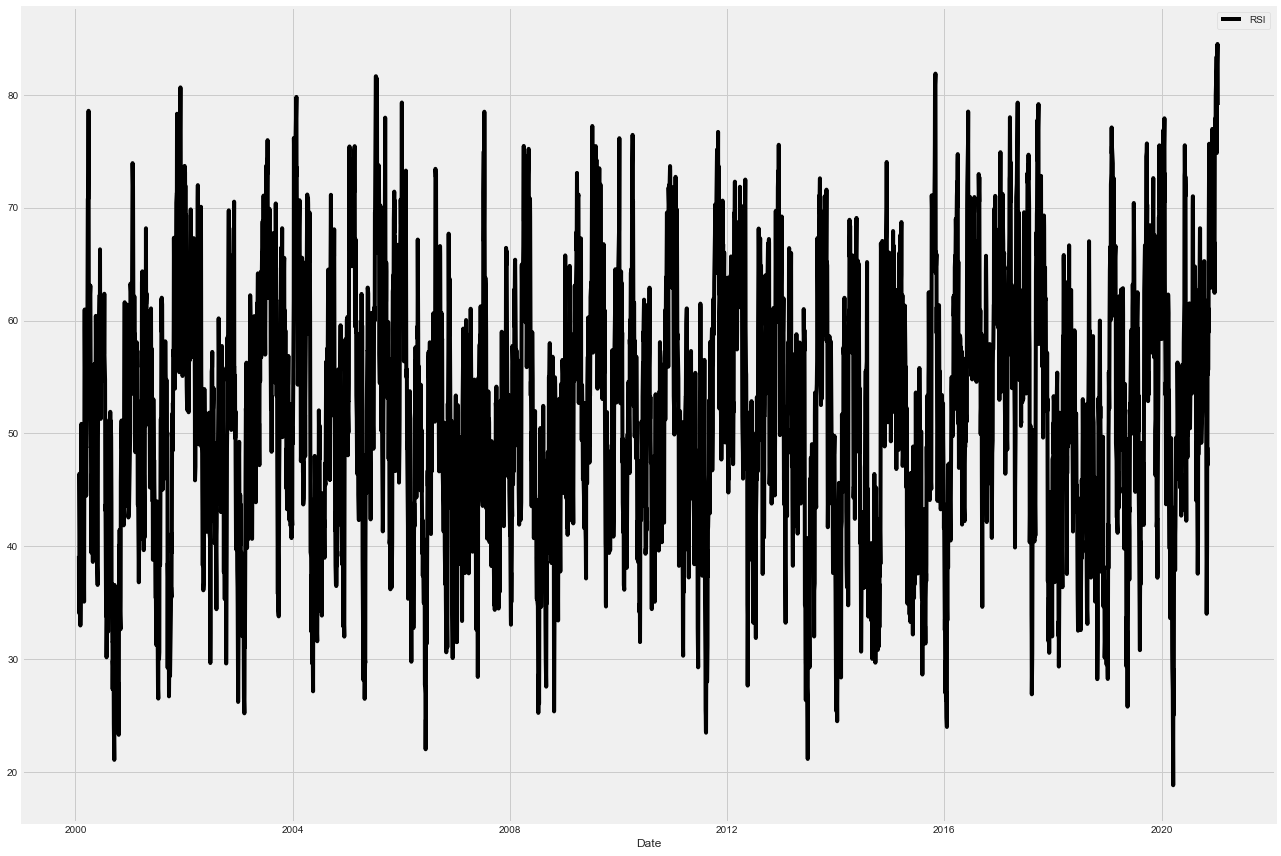

In [26]:
# rsi
def plot_rsi(data, interval):
    rsi = talib.RSI(data, timeperiod=interval)
    plt.figure(figsize=(20, 15))
    plt.xlabel('Date')
    rsi = plt.plot(rsi, color='black', label = 'RSI')
    plt.legend(loc='best')
    plt.show()
plot_rsi(samsung['Close'], 14)

In [34]:
macd

Date
2000-01-04            NaN
2000-01-05            NaN
2000-01-06            NaN
2000-01-07            NaN
2000-01-10            NaN
                 ...     
2021-01-07    3915.864554
2021-01-08    4384.500594
2021-01-11    4877.198339
2021-01-12    5175.725651
2021-01-13    5278.837071
Length: 5192, dtype: float64

In [37]:
df = samsung.copy()
df['change'] = df['Close'].pct_change()
df['output'] = df.apply(lambda x : 1 if x['change'] > 0 else 0, axis=1)
df = df[1:]
df['output_sft'] = df['output'].shift(-1)
df

,Close,change,output,output_sft
Date,,,,
2000-01-05,5580,-0.086743,0,1.0
2000-01-06,5620,0.007168,1,0.0
2000-01-07,5540,-0.014235,0,1.0
2000-01-10,5770,0.041516,1,0.0
2000-01-11,5770,0.000000,0,0.0
...,...,...,...,...
2021-01-07,82900,0.008516,1,1.0
2021-01-08,88800,0.071170,1,1.0
2021-01-11,91000,0.024775,1,0.0


In [45]:
merge_df = pd.concat([df['output_sft'], macd, macdsignal], axis=1, join='inner')
merge_df.rename(columns={0:'macd', 1:'macdsignal'}, inplace=True)
merge_df.dropna(inplace=True)
merge_df

,output_sft,macd,macdsignal
Date,,,
2000-02-21,1.0,-188.254218,-168.760665
2000-02-22,1.0,-188.579992,-172.724531
2000-02-23,0.0,-185.090727,-175.197770
2000-02-24,1.0,-185.831722,-177.324560
2000-02-25,0.0,-180.305929,-177.920834
...,...,...,...
2021-01-06,1.0,3861.483796,3250.585248
2021-01-07,1.0,3915.864554,3383.641109
2021-01-08,1.0,4384.500594,3583.813006


In [51]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# xgboost
# 분할 - 1 비율 (가장 기본)
def dataSplitPercent(df, outputColNm='diff_1', tsize=0.15, vsize=0.15, drawGraph=True, gtype='scatter') : 
    # 정규화
    tmp_df = df.copy()
    tmp_df.drop([outputColNm], axis=1, inplace=True)
    min_max_scaler = MinMaxScaler()
    trans_df = min_max_scaler.fit_transform(tmp_df)
    tmp_df = pd.DataFrame(trans_df, columns=tmp_df.columns, index=list(tmp_df.index.values))
    tmp_df[outputColNm] = df[outputColNm]
    df = tmp_df
    
    test_size = tsize
    valid_size = vsize

    test_split_idx = int(df.shape[0] * (1 - test_size)) # 85%
    valid_split_idx = int(df.shape[0] * (1 - (valid_size + test_size))) # 70%

    train_df = df.iloc[:valid_split_idx].copy()
    valid_df = df.iloc[valid_split_idx + 1:test_split_idx].copy()
    test_df = df.iloc[test_split_idx + 1:].copy()
    
    if drawGraph : 
        if gtype == 'hist' :
            fig = go.Figure()
            fig.add_trace(go.Histogram(x=train_df.index, y=train_df[outputColNm], name='Training'))
            fig.add_trace(go.Histogram(x=valid_df.index, y=valid_df[outputColNm], name='Validation'))
            fig.add_trace(go.Histogram(x=test_df.index, y=test_df[outputColNm], name='Test'))
            fig.show()
        else :
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=train_df.index, y=train_df[outputColNm], name='Training'))
            fig.add_trace(go.Scatter(x=valid_df.index, y=valid_df[outputColNm], name='Validation'))
            fig.add_trace(go.Scatter(x=test_df.index, y=test_df[outputColNm], name='Test'))
            fig.show()
    return train_df, test_df, valid_df

# XGBoost
def xgBoostGridSearch(trainTuple, validTuple, paramDic, colNmList, obj='reg:squarederror') :
    parameters = {
        'booster' :['gbtree'],
        'learning_rate':paramDic['learning_rate'],
        'n_estimators':paramDic['n_estimators'],
        'max_depth':paramDic['max_depth'],
        'gamma':paramDic['gamma'],
        'random_state':paramDic['random_state'],
        #'early_stoppings':paramDic['early_stoppings']
    }
    cv=TimeSeriesSplit(n_splits=5)
    #eval_set = [trainTuple, validTuple]
    # objective : 목적함수. 이 함수를 통해 나온 값이 최소화되는 방향으로 학습된다.
    # binary:logistic : 이항 분류(binary class)에 사용
    # multi:softmax / multi:softprob : 다항 분류(multi class)에 사용.
    if obj == 'binary:logistic' :
        model = xgb.XGBClassifier(objective=obj)
        em = 'logloss'
    else :
        model = xgb.XGBRegressor(objective=obj)
        em = 'rmse'
    
    clf = GridSearchCV(model, parameters, cv=cv)
    
    dtrain = pd.DataFrame(trainTuple[0], columns=colNmList)
    clf.fit(dtrain, trainTuple[1], eval_metric=em)
    print(f'Best params : {clf.best_params_}')
    print(f'Best validation score = {clf.best_score_}')
    return clf

def xgBoost(clf, trainTuple, validTuple, colNmList, obj='reg:squarederror', fiGraph=True) :
    dtrain = pd.DataFrame(trainTuple[0], columns=colNmList)
    dvalid = pd.DataFrame(validTuple[0], columns=colNmList)
    #eval_set = [(dtrain, trainTuple[1]), (dvalid, validTuple[1])]
    eval_set = [(dvalid, validTuple[1])]
    
    if obj == 'binary:logistic' :
        model = xgb.XGBClassifier(**clf.best_params_, objective=obj)
        em = 'logloss'
    else :
        model = xgb.XGBRegressor(**clf.best_params_, objective=obj)
        em = 'rmse'
    
    model.fit(dtrain, trainTuple[1], eval_set=eval_set, verbose=False, eval_metric=em)
    model.get_booster().get_score(importance_type='weight')
    
    if fiGraph :
        plot_importance(model)
        
    return model

def pred(model, testTuple, df, test_df, colNmList, colNm, graphStyle='scatter') :
    dtrain = pd.DataFrame(trainTuple[0], columns=colNmList)
    dtest = pd.DataFrame(testTuple[0], columns=colNmList)
    y_pred = model.predict(dtest)
    print(f'mean_squared_error = {mean_squared_error(testTuple[1], y_pred)}')
    
    accuracy = accuracy_score(testTuple[1], y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    # 예측값과 실제값 그려보기
    predicted_prices = test_df.copy()
    predicted_prices[colNm] = y_pred

    fig = make_subplots(rows=2, cols=1)
    
    if graphStyle == 'scatter' :
        fig.add_trace(go.Scatter(x=df.index, y=df[colNm], name='Truth', marker_color='LightSkyBlue'), row=1, col=1)
        fig.add_trace(go.Scatter(x=predicted_prices.index, y=predicted_prices[colNm], name='Prediction', marker_color='MediumPurple'), row=1, col=1)

        fig.add_trace(go.Scatter(x=predicted_prices.index, y=testTuple[1], name='Truth', marker_color='LightSkyBlue', showlegend=False), row=2, col=1)
        fig.add_trace(go.Scatter(x=predicted_prices.index, y=y_pred, name='Prediction', marker_color='MediumPurple', showlegend=False), row=2, col=1)
    
    fig.show()

In [48]:
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# 주피터 노트북에서 plotly 사용하기
init_notebook_mode(connected=True)

# 기본 배경색 바꾸기
layout = go.Layout(paper_bgcolor='rgba(0, 0, 0, 0)', plot_bgcolor='rgba(250, 250, 250, 0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

train_df, test_df, valid_df = dataSplitPercent(merge_df, 'output_sft')
train_df

,macd,macdsignal,output_sft
2000-02-21,0.394931,0.390041,1.0
2000-02-22,0.394894,0.389476,1.0
2000-02-23,0.395288,0.389123,0.0
2000-02-24,0.395204,0.388820,1.0
2000-02-25,0.395828,0.388735,0.0
...,...,...,...
2014-09-18,0.369378,0.344113,0.0
2014-09-19,0.372260,0.347011,0.0
2014-09-22,0.371059,0.349026,0.0
2014-09-23,0.365773,0.349302,0.0


Best params : {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'random_state': 50}
Best validation score = 0.5214642262895175
mean_squared_error = 0.5304010349288486
Accuracy: 46.96%


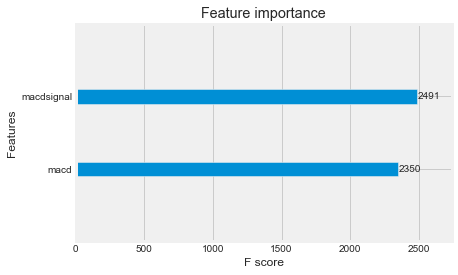

In [52]:
# X, y 분리
outputColNm = 'output_sft'

y_train = train_df[outputColNm].copy()
X_train = train_df.drop([outputColNm], 1)
trainTuple = (X_train, y_train)

y_valid = valid_df[outputColNm].copy()
X_valid = valid_df.drop([outputColNm], 1)
validTuple = (X_valid, y_valid)

y_test = test_df[outputColNm].copy()
X_test = test_df.drop([outputColNm], 1)
testTuple = (X_test, y_test)

# XGBoost 학습, feature importance 로 중요한 feature 찾기
paramDic = {}
paramDic['n_estimators'] = [100, 200, 300]
paramDic['max_depth'] = [5, 7, 8]
paramDic['gamma'] = [0]
paramDic['random_state'] = [50, 100]
paramDic['learning_rate'] = [0.1, 0.2]

binaryObj = 'binary:logistic'
clf = xgBoostGridSearch(trainTuple, validTuple, paramDic, X_train.columns, obj=binaryObj)
model = xgBoost(clf, trainTuple, validTuple, X_train.columns, obj=binaryObj)

#clf = xgBoostGridSearch(trainTuple, validTuple, paramDic, X_train.columns)
#model = xgBoost(clf, trainTuple, validTuple, X_train.columns)

#9. 예측
pred(model, testTuple, df, test_df, X_train.columns, colNm=outputColNm)

<AxesSubplot:xlabel='stateDt'>

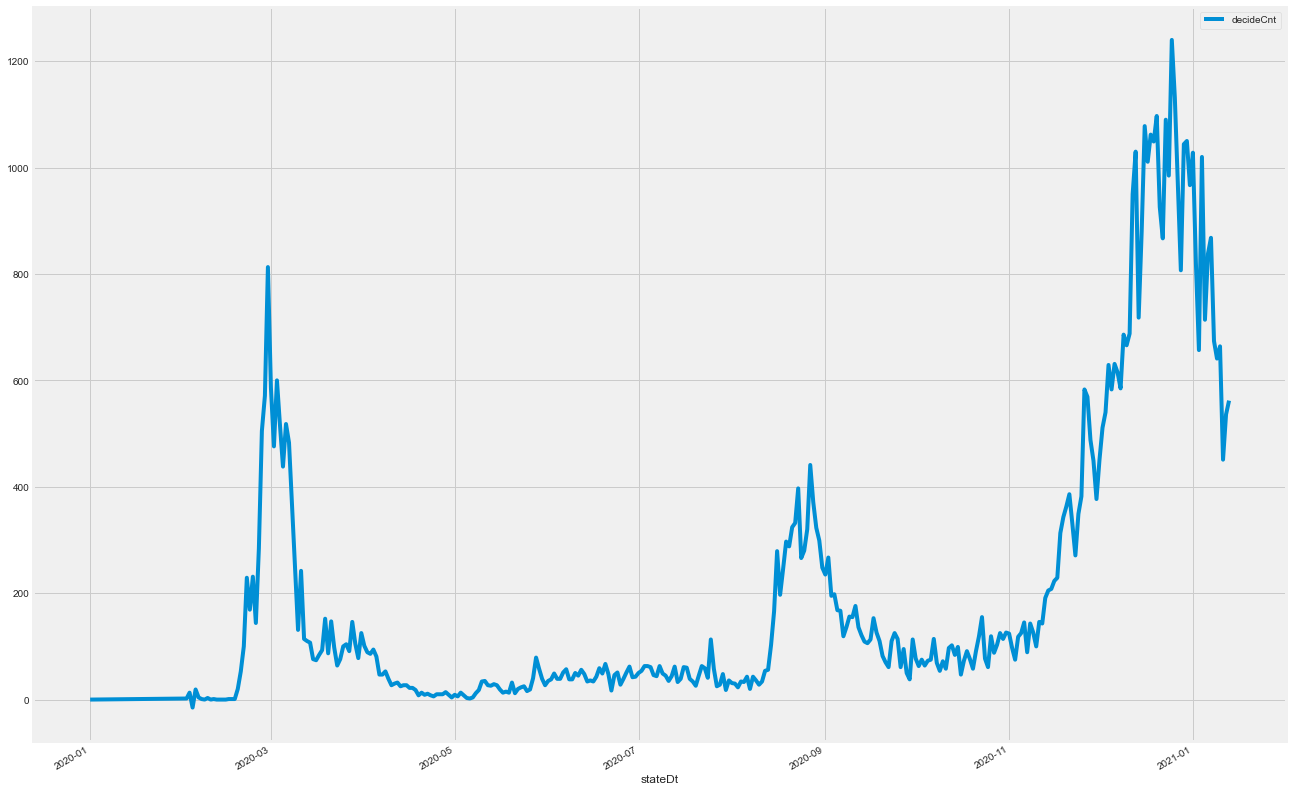

In [65]:
import requests 
import xmltodict 
import json 
import datetime
from urllib import parse
import pandas as pd

def getCovidKR(end_day, start_day): 
    url='http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson' #ServiceKey는 url decode 한 값임. 
    serviceKey='wMFqCOL2ZotVqyvmw311lh7pNf%2BKvsIH%2FqiMtduIe%2FYd%2B%2B537ffxw%2Brmt5tfsFMY3Xg%2BGWEWmmAm97QnJM6RMw%3D%3D'
    serviceKey_decode=parse.unquote(serviceKey)

    payload = {'ServiceKey':serviceKey_decode, 'startCreateDt':start_day, 'endCreateDt':end_day } 
  
    res = requests.get(url, params=payload) 
    if (res.status_code == 200): # Ordered dictionary type
        result = xmltodict.parse(res.text) #dictionlay type 
        dd = json.loads(json.dumps(result)) 
        #print(dd)
        data = pd.json_normalize(dd['response']['body']['items']['item']) ## json_normalize를 이용해서 계층 구조를 없애고 dataframe으로 불러옴 
        #print(data)
        covid_data = data[['stateDt','decideCnt']]
        covid_data['stateDt'] = pd.to_datetime(covid_data['stateDt'], format='%Y-%m-%d')
        #covid_data.astype({'decideCnt':'int'}) ## 타입변환 안됨
        #pd.to_numeric(covid_data['decideCnt']) ## 타입변환 안됨
        covid_data['decideCnt'] = covid_data['decideCnt'].apply(pd.to_numeric)
        covid_data.drop_duplicates("stateDt", keep="first", inplace=True) ## 중복값 제거
        covid_data.sort_values(by=['stateDt'], inplace=True, ascending=False)  ## 날짜순 정렬
        covid_data['decideCnt'] = (covid_data.decideCnt - covid_data.decideCnt.shift(-1)).fillna(0)
        return covid_data

    else: 
        print ('res.status_code is NOT ok')
    
today =datetime.datetime.now() 
yesterday = today - datetime.timedelta(1) 
d1 = today.strftime("%Y%m%d")
d2 = '20000103'
covid_df = getCovidKR(d1,d2)
covid_df.set_index('stateDt', drop=True, inplace=True)
#covid_df

fig = plt.figure(figsize=(20, 15))
ax = fig.subplots()
covid_df.plot(ax=ax)

<AxesSubplot:xlabel='Date'>

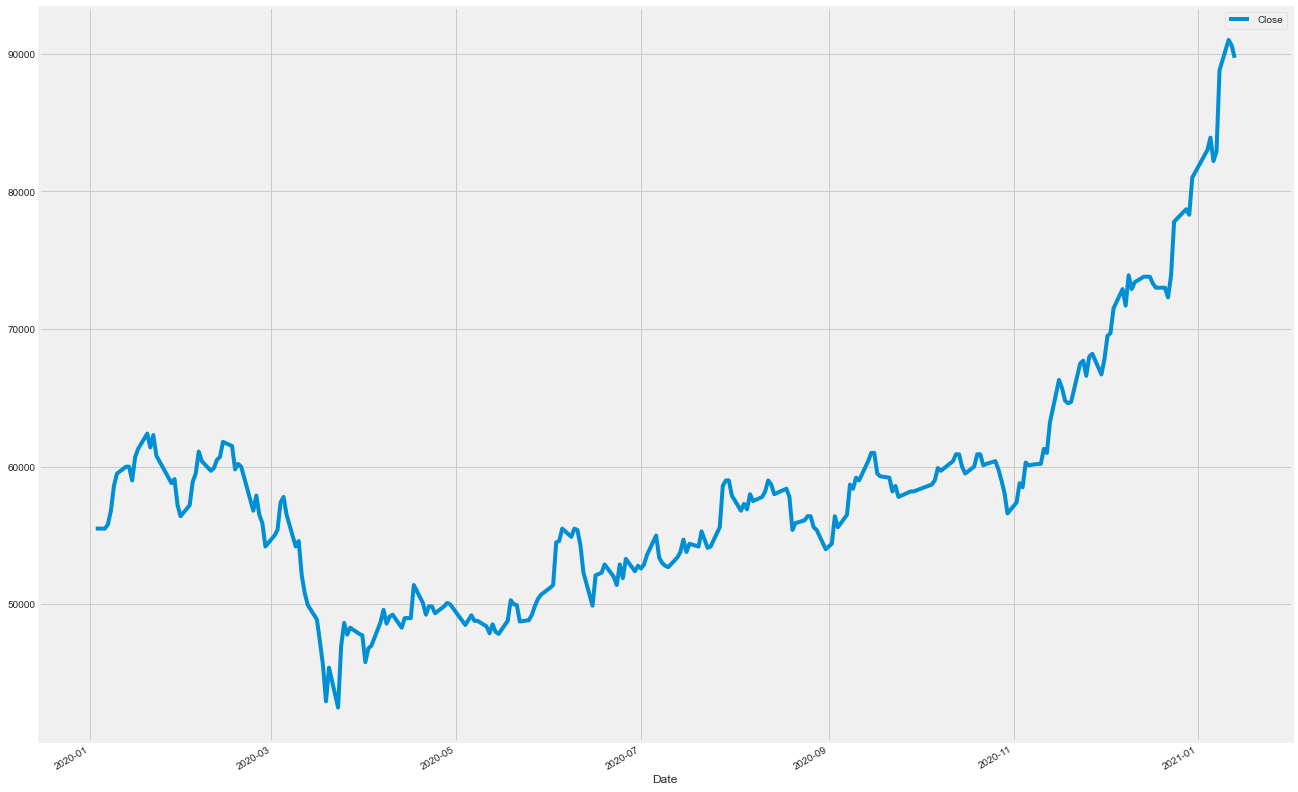

In [67]:
fig = plt.figure(figsize=(20, 15))
ax = fig.subplots()
samsung['2020-01-03':].plot(ax=ax)

In [ ]:
# 금리, 환율, 반도체지수, 유가, 금, 코스피, 경쟁사 (SK-하이닉스, 애플, 인텔)


In [68]:
# 재무제표 가져오기
# 공시일 가져오기 (rcept_dt)
# 'A'=정기공시, 'B'=주요사항보고, 'C'=발행공시, 'D'=지분공시, 'E'=기타공시, 'F'=외부감사관련, 'G'=펀드공시, 'H'=자산유동화, 'I'=거래소공시, 'J'=공정위공시
def getRceptDt(stock_code, start, end) :
    list_df = dart.list(stock_code, kind='A', start=start, end=end)
    if list_df is None or list_df.empty :
        return None
    list_df = list_df[['report_nm', 'rcept_dt']]
    list_df['report_nm'] = list_df['report_nm'].str.split('(').str[1]
    list_df['report_nm'] = list_df['report_nm'].str.replace(')', '')
    list_df = list_df.rename({'report_nm':'기준일', 'rcept_dt':'접수일자'}, axis=1)
    return list_df

# 날짜 맞춰주기
def setDate(year, reprt_code) :
    thstrm_dt = ''
    if reprt_code == '11013' :
        thstrm_dt = str(year) + '.03'
    elif reprt_code == '11012' :
        thstrm_dt = str(year) + '.06'
    elif reprt_code == '11014' :
        thstrm_dt = str(year) + '.09'
    else :
        thstrm_dt = str(year) + '.12'
    return thstrm_dt

# 배당 정보 가져오기
def getDistribution(stock_code, year, reprt_code) :
    thstrm_dt = setDate(year, reprt_code)
        
    # report_code : '11013'=1분기보고서, '11012'=반기보고서, '11014'=3분기보고서, '11011'=사업보고서
    fs = dart.report(stock_code, '배당', year, reprt_code=reprt_code)
    if not fs is None :
        fs_tmp = fs.copy()
        # debug
        '''
        print(thstrm_dt)
        if thstrm_dt == '2016.06' and stock_code == '000660' :
            pdb.set_trace()
        '''
        
        # 전체
        if 'stock_knd' in fs_tmp.columns :
            fs_all = fs_tmp[fs_tmp['stock_knd'] != fs_tmp['stock_knd']]
            fs_all.drop(['stock_knd'], inplace=True, axis=1)
        else :
            fs_all = fs_tmp
            
        fs_all_ret = fs_all[['thstrm']]
        fs_all_ret = fs_all_ret.T
        fs_all_ret.reset_index(drop=True, inplace=True)
        fs_all_ret.columns = list(fs_all['se'])
        fs_all_ret['기준일'] = thstrm_dt
        
        if 'stock_knd' in fs_tmp.columns :
            # 보통주
            fs_n = fs_tmp[(fs_tmp['stock_knd'] == fs_tmp['stock_knd']) & (fs_tmp['stock_knd'].str.contains('보통주'))]
            fs_n_ret = fs_n[['thstrm']]
            fs_n_ret = fs_n_ret.T
            fs_n_ret.reset_index(drop=True, inplace=True)
            fs_n_ret.columns = list(fs_n['se'])
            fs_n_ret['기준일'] = thstrm_dt
            
            # 우선주
            fs_p = fs_tmp[(fs_tmp['stock_knd'] == fs_tmp['stock_knd']) & (fs_tmp['stock_knd'].str.contains('우선주'))]
            fs_p_ret = fs_p[['thstrm']]
            fs_p_ret = fs_p_ret.T
            fs_p_ret.reset_index(drop=True, inplace=True)
            fs_p_ret.columns = list(fs_p['se'])
            fs_p_ret['기준일'] = thstrm_dt
        else :
            fs_n_ret = pd.DataFrame()
            fs_p_ret = pd.DataFrame()
            
        filter_col = ['기준일']    
        for col in fs_all_ret.columns :
            if '주당액면가액' in col:
                filter_col.append(col)
            if '당기순이익' in col :
                filter_col.append(col)
            if '주당순이익' in col :
                filter_col.append(col)
            if '현금배당총액' in col :
                filter_col.append(col)
            if '주식배당금총액' in col :
                filter_col.append(col)
            if '현금배당성향' in col :
                filter_col.append(col)

        fs_all_ret = fs_all_ret[filter_col]
        
        return (fs_all_ret, fs_n_ret, fs_p_ret)
    else :
        return (pd.DataFrame(), pd.DataFrame(), pd.DataFrame())
    
# 재무제표 가져오기
def getFinancialStates(stock_code, year, reprt_code) :
    # report_code : '11013'=1분기보고서, '11012'=반기보고서, '11014'=3분기보고서, '11011'=사업보고서
    fs = dart.finstate(stock_code, year, reprt_code=reprt_code)
    if not fs is None :
        # 연결재무제표
        fs_cfs = fs[fs['fs_div'].str.contains('CFS')]
        # 손익계산서
        fs_is = fs_cfs[fs_cfs['sj_div'].str.contains('IS')]
        # 재무제표
        fs_bs = fs_cfs[fs_cfs['sj_div'].str.contains('BS')]
        return (fs_is, fs_bs)
    else :
        return (pd.DataFrame(), pd.DataFrame())
    
# 재무제표 df 를 변환하기
def chDf(fs, year, reprt_code) :
    fs_tmp = fs.copy()
    ret = fs_tmp[['thstrm_amount']]
    ret = ret.T
    ret.reset_index(drop=True, inplace=True)
    ret.columns = list(fs_tmp['account_nm'])
    ret['기준일'] = setDate(year, reprt_code)
    return ret

# 비율 계산 : 몇 가지만 해보기
# 아래 식들은 검증이 필요!! 대충 한것
# 현금흐름표도 추가해야 함
def financialIndicator(fs) :
    fs_tmp = fs.copy()
    
    # 안정성
    # 유동비율
    # 단기채무에 대하여 이를 상환하기 위한 유동자산의 상대적 크기를 나타내는 지표
    # ( 유동자산 / 유동부채 ) × 100
    fs_tmp['유동비율'] = fs_tmp.apply(lambda x : (x['유동자산'] / x['유동부채']) * 100, axis=1)
    
    # 성장성
    # 매출증가율  
    # 전년도에 비하여 금년도의 매출액이 어느정도 증가하였는지 나타내는 지표
    # ( 금년도 매출액 - 전년도매출액)  / 전년도 매출액  × 100  
    fs_tmp['매출증가율'] = fs_tmp['매출액'].pct_change() * 100
    
    # 총자산증가율  
    # 전년도에 비하여 금년도의 총자산이 어느정도 증가하였는지 나타내는 지표
    # ( 금년도 총자산 - 전년도 총자산 ) / 전년도 총자산 × 100  
    fs_tmp['총자산증가율'] = fs_tmp['자산총계'].pct_change() * 100

    # 순이익증가율  
    # 전년도에 비하여 금년도의 당기순이익이 어느정도 증가하였는지 나타내는 지표
    # ( 금년도 당기순이익 - 전년도 당기순이익 ) / 전년도 당기순이익 × 100  
    fs_tmp['순이익증가율'] = fs_tmp['당기순이익'].pct_change() * 100
    
    # 수익성
    # 매출액 이익율  
    # 매출액에 이익의 상대적 크기를 나타내는 지표
    # ㉡ 매출액영업이익율: (영업이익/매출액) × 100  
    # ㉢ 매출액경상이익율: (세전이익/매출액) × 100  
    # ㉣ 매출액순이익율: (당기순이익/매출액) × 100  
    fs_tmp['매출액영업이익률(OPM)'] = fs_tmp.apply(lambda x : (x['영업이익'] / x['매출액']) * 100, axis=1)
    fs_tmp['매출액경상이익률'] = fs_tmp.apply(lambda x : (x['법인세차감전 순이익'] / x['매출액']) * 100, axis=1)
    fs_tmp['매출액순이익률(NPM)'] = fs_tmp.apply(lambda x : (x['당기순이익'] / x['매출액']) * 100, axis=1)

    # 활동성
    # 총자산회전율  
    # 보통주 1주당 분배될 수 있는 순이익금을 표시하는 것으로 당기순이익과 경영성과를 측정하는 중요한 지표  
    # ( 매출액 / 평균총자산 ) × 100  
    fs_tmp['총자산회전율'] = fs_tmp.apply(lambda x : (x['매출액'] / x['자산총계']) * 100, axis=1)
  
    # 기타
    fs_tmp['ROE'] = fs_tmp.apply(lambda x : (x['당기순이익'] / x['자본총계']) * 100, axis=1)
    fs_tmp['ROA'] = fs_tmp.apply(lambda x : (x['당기순이익'] / x['자산총계']) * 100, axis=1)
    
    return fs_tmp

In [71]:
import OpenDartReader
# 하루에 10000건 제한 : 본인 걸로 변경해야 함.
#api_key='4fe6210e312a894fa74d61109db992ae0be89e65'
api_key = '61a188705952b27d228c3a00b3c383c9f8fa8938'
dart = OpenDartReader(api_key) 

In [79]:
stock_code = '005930'
start_year = 2000
end_year = 2021
corp_code = dart.find_corp_code(stock_code)
if corp_code is None:
    print('corp code is None')
fs_list = getRceptDt(stock_code, str(start_year) + '-01-01', str(end_year) + '-12-31')
if fs_list is None or fs_list.empty:
    print('fs_list is None')

fs_all_t = pd.DataFrame()
fs_n_t = pd.DataFrame()
fs_p_t = pd.DataFrame()
for i in range(start_year, end_year) :
    for j in ['11013', '11012', '11014', '11011'] :
        fs_all, fs_n, fs_p = getDistribution(stock_code, i, j)
        if not fs_all.empty :
            fs_all_t = pd.concat([fs_all_t, fs_all])
        if not fs_n.empty :    
            fs_n_t = pd.concat([fs_n_t, fs_n])
        if not fs_p.empty :
            fs_p_t = pd.concat([fs_p_t, fs_p])
# 재무제표 만들기
fs_is_t = pd.DataFrame()
fs_bs_t = pd.DataFrame()
for i in range(start_year, end_year) :
    for j in ['11013', '11012', '11014', '11011'] :
        fs_is, fs_bs = getFinancialStates(stock_code, i, j)
        if not fs_is.empty :
            fs_is_t = pd.concat([fs_is_t, chDf(fs_is, i, j)])
        if not fs_bs.empty :    
            fs_bs_t = pd.concat([fs_bs_t, chDf(fs_bs, i, j)])

if not fs_is_t.empty and not fs_bs_t.empty :
    fs_is_tmp = fs_is_t.copy()
    fs_bs_tmp = fs_bs_t.copy()

    for col in fs_is_tmp.columns :
        if col == '기준일' :
            print('1')
        else :
            fs_is_tmp[col] = pd.to_numeric(fs_is_tmp[col].str.replace(',', ''))

    for col in fs_bs_tmp.columns :
        if col == '기준일' :
            print('2')
        else :
            fs_bs_tmp[col] = pd.to_numeric(fs_bs_tmp[col].str.replace(',', ''))
    
    fs = pd.merge(fs_list, fs_all_t, on='기준일', how='outer')
    fs = pd.merge(fs, fs_bs_tmp, on='기준일', how='outer')
    fs = pd.merge(fs, fs_is_tmp, on='기준일', how='outer')
    fs = pd.merge(fs, fs_n_t, on='기준일', how='outer')
    fs = pd.merge(fs, fs_p_t, on='기준일', how='outer')
    
    fs = pd.merge(fs_list, fs_bs_tmp, on='기준일', how='outer')
    fs = pd.merge(fs, fs_is_tmp, on='기준일', how='outer')

    fs_all = financialIndicator(fs)
    fs_all['접수일자'] = pd.to_datetime(fs_all['접수일자'], format="%Y/%m/%d")
    # 종가 가져오기
    price_df = fdr.DataReader(stock_code, str(start_year))
    price_df['접수일자'] = price_df.index

    fs_all = pd.merge(fs_all, price_df[['Close', '접수일자']], on='접수일자', how='left')

    # 파일로 저장
    #fs_all.to_csv('./'+stock_code+'.csv', encoding='euc-kr')
fs_all

1
2


,기준일,접수일자,유동자산,비유동자산,자산총계,유동부채,비유동부채,부채총계,이익잉여금,자본총계,...,매출증가율,총자산증가율,순이익증가율,매출액영업이익률(OPM),매출액경상이익률,매출액순이익률(NPM),총자산회전율,ROE,ROA,Close
0,2020.09,2020-11-16,2.036349e+14,1.721538e+14,3.757887e+14,7.304640e+13,2.660615e+13,9.965255e+13,2.670249e+14,2.761362e+14,...,NaN,NaN,NaN,18.447537,19.180568,13.978661,17.819629,3.389883,2.490946,66300.0
1,2020.06,2020-08-14,1.861368e+14,1.718227e+14,3.579595e+14,6.186372e+13,2.628796e+13,8.815168e+13,2.601651e+14,2.698078e+14,...,-20.903746,-4.744486,-40.655216,15.380188,14.669177,10.487989,14.796686,2.058904,1.551875,58000.0
2,2020.03,2020-05-15,1.867397e+14,1.707178e+14,3.574575e+14,6.476329e+13,2.630652e+13,9.106981e+13,2.570789e+14,2.663877e+14,...,4.453857,-0.140229,-12.063852,11.653546,12.212978,8.829481,15.477413,1.833765,1.366575,47850.0
3,2019.12,2020-03-30,1.813853e+14,1.711792e+14,3.525645e+14,6.378276e+13,2.590131e+13,8.968408e+13,2.545829e+14,2.628804e+14,...,316.448513,-1.368845,345.019331,12.052258,13.208365,9.435235,65.349995,8.269488,6.165926,47850.0
4,2019.09,2019-11-14,1.860421e+14,1.673439e+14,3.533860e+14,6.330319e+13,2.664055e+13,8.994374e+13,2.517613e+14,2.634422e+14,...,-73.088874,0.233004,-71.076392,12.544285,13.903622,10.140826,17.545538,2.386733,1.779262,52800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2001.03,2001-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,4340.0
80,2000.09,2000-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,3290.0
81,2000.06,2000-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,6020.0
82,1999.12,2000-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,7050.0


In [85]:
fs_all.dropna(inplace=True)
fs_all

,기준일,접수일자,유동자산,비유동자산,자산총계,유동부채,비유동부채,부채총계,이익잉여금,자본총계,...,매출증가율,총자산증가율,순이익증가율,매출액영업이익률(OPM),매출액경상이익률,매출액순이익률(NPM),총자산회전율,ROE,ROA,Close
1,2020.06,2020-08-14,1.861368e+14,1.718227e+14,3.579595e+14,6.186372e+13,2.628796e+13,8.815168e+13,2.601651e+14,2.698078e+14,...,-20.903746,-4.744486,-40.655216,15.380188,14.669177,10.487989,14.796686,2.058904,1.551875,58000.0
2,2020.03,2020-05-15,1.867397e+14,1.707178e+14,3.574575e+14,6.476329e+13,2.630652e+13,9.106981e+13,2.570789e+14,2.663877e+14,...,4.453857,-0.140229,-12.063852,11.653546,12.212978,8.829481,15.477413,1.833765,1.366575,47850.0
3,2019.12,2020-03-30,1.813853e+14,1.711792e+14,3.525645e+14,6.378276e+13,2.590131e+13,8.968408e+13,2.545829e+14,2.628804e+14,...,316.448513,-1.368845,345.019331,12.052258,13.208365,9.435235,65.349995,8.269488,6.165926,47850.0
4,2019.09,2019-11-14,1.860421e+14,1.673439e+14,3.533860e+14,6.330319e+13,2.664055e+13,8.994374e+13,2.517613e+14,2.634422e+14,...,-73.088874,0.233004,-71.076392,12.544285,13.903622,10.140826,17.545538,2.386733,1.779262,52800.0
5,2019.06,2019-08-14,1.734335e+14,1.695067e+14,3.429401e+14,5.930927e+13,2.588383e+13,8.519310e+13,2.480610e+14,2.577470e+14,...,-9.477481,-2.955932,-17.607302,11.753795,12.791260,9.230079,16.366444,2.009946,1.510636,43700.0
6,2019.03,2019-05-15,1.773885e+14,1.676794e+14,3.450679e+14,6.735409e+13,2.449864e+13,9.185273e+13,2.454010e+14,2.532152e+14,...,-6.666223,0.620443,-2.644320,11.898859,13.196346,9.627818,15.181229,1.991818,1.461621,42550.0
7,2018.12,2019-04-01,1.746974e+14,1.646598e+14,3.393572e+14,6.908151e+13,2.252256e+13,9.160407e+13,2.426990e+14,2.477532e+14,...,365.340984,-1.654932,779.232867,24.156511,25.089061,18.191164,71.833273,17.898805,13.067308,45050.0
8,2018.09,2018-11-14,1.762820e+14,1.609137e+14,3.371958e+14,7.470587e+13,2.038675e+13,9.509263e+13,2.416283e+14,2.421032e+14,...,-73.146977,-0.636927,-70.344442,26.848254,27.450880,20.089698,19.413052,5.431864,3.900024,44100.0
9,2018.06,2018-08-14,1.569768e+14,1.617115e+14,3.186884e+14,6.560232e+13,1.996121e+13,8.556354e+13,2.310652e+14,2.331248e+14,...,-10.658930,-5.488623,-16.024247,25.424691,26.344281,18.883225,18.351048,4.737124,3.465270,45150.0
10,2018.03,2018-05-15,1.549420e+14,1.575312e+14,3.124731e+14,6.829859e+13,2.091465e+13,8.921323e+13,2.224854e+14,2.232599e+14,...,3.558416,-1.950265,5.841782,25.827627,26.708909,19.299583,19.382056,5.235398,3.740656,49200.0


In [134]:
fs_all_tmp = fs_all.copy()
fs_all_tmp.set_index('접수일자', drop=True, inplace=True)
fs_all_tmp = fs_all_tmp[::-1]

In [135]:
fs_all_tmp.set_index(pd.DatetimeIndex(fs_all_tmp.index), drop=True, inplace=True)
fs_all_tmp

,기준일,유동자산,비유동자산,자산총계,유동부채,비유동부채,부채총계,이익잉여금,자본총계,자본금,...,매출증가율,총자산증가율,순이익증가율,매출액영업이익률(OPM),매출액경상이익률,매출액순이익률(NPM),총자산회전율,ROE,ROA,Close
접수일자,,,,,,,,,,,,,,,,,,,,,
2017-11-14,2017.09,1.453223e+14,1.512562e+14,2.965786e+14,6.617258e+13,1.971474e+13,8.588733e+13,2.067730e+14,2.106913e+14,8.975140e+11,...,-74.100468,-1.714491,-73.466997,23.422105,24.037074,18.039660,20.921572,5.312708,3.774181,55920.0
2018-04-02,2017.12,1.469825e+14,1.547696e+14,3.017521e+14,6.717511e+13,2.008555e+13,8.726066e+13,2.158112e+14,2.144914e+14,8.975140e+11,...,295.575767,-3.431023,260.923884,22.391716,23.456487,17.608966,79.394769,19.668267,13.980598,48540.0
2018-05-15,2018.03,1.549420e+14,1.575312e+14,3.124731e+14,6.829859e+13,2.091465e+13,8.921323e+13,2.224854e+14,2.232599e+14,8.975140e+11,...,3.558416,-1.950265,5.841782,25.827627,26.708909,19.299583,19.382056,5.235398,3.740656,49200.0
2018-08-14,2018.06,1.569768e+14,1.617115e+14,3.186884e+14,6.560232e+13,1.996121e+13,8.556354e+13,2.310652e+14,2.331248e+14,8.975140e+11,...,-10.658930,-5.488623,-16.024247,25.424691,26.344281,18.883225,18.351048,4.737124,3.465270,45150.0
2018-11-14,2018.09,1.762820e+14,1.609137e+14,3.371958e+14,7.470587e+13,2.038675e+13,9.509263e+13,2.416283e+14,2.421032e+14,8.975140e+11,...,-73.146977,-0.636927,-70.344442,26.848254,27.450880,20.089698,19.413052,5.431864,3.900024,44100.0
2019-04-01,2018.12,1.746974e+14,1.646598e+14,3.393572e+14,6.908151e+13,2.252256e+13,9.160407e+13,2.426990e+14,2.477532e+14,8.975140e+11,...,365.340984,-1.654932,779.232867,24.156511,25.089061,18.191164,71.833273,17.898805,13.067308,45050.0
2019-05-15,2019.03,1.773885e+14,1.676794e+14,3.450679e+14,6.735409e+13,2.449864e+13,9.185273e+13,2.454010e+14,2.532152e+14,8.975140e+11,...,-6.666223,0.620443,-2.644320,11.898859,13.196346,9.627818,15.181229,1.991818,1.461621,42550.0
2019-08-14,2019.06,1.734335e+14,1.695067e+14,3.429401e+14,5.930927e+13,2.588383e+13,8.519310e+13,2.480610e+14,2.577470e+14,8.975140e+11,...,-9.477481,-2.955932,-17.607302,11.753795,12.791260,9.230079,16.366444,2.009946,1.510636,43700.0
2019-11-14,2019.09,1.860421e+14,1.673439e+14,3.533860e+14,6.330319e+13,2.664055e+13,8.994374e+13,2.517613e+14,2.634422e+14,8.975140e+11,...,-73.088874,0.233004,-71.076392,12.544285,13.903622,10.140826,17.545538,2.386733,1.779262,52800.0


<AxesSubplot:xlabel='접수일자'>

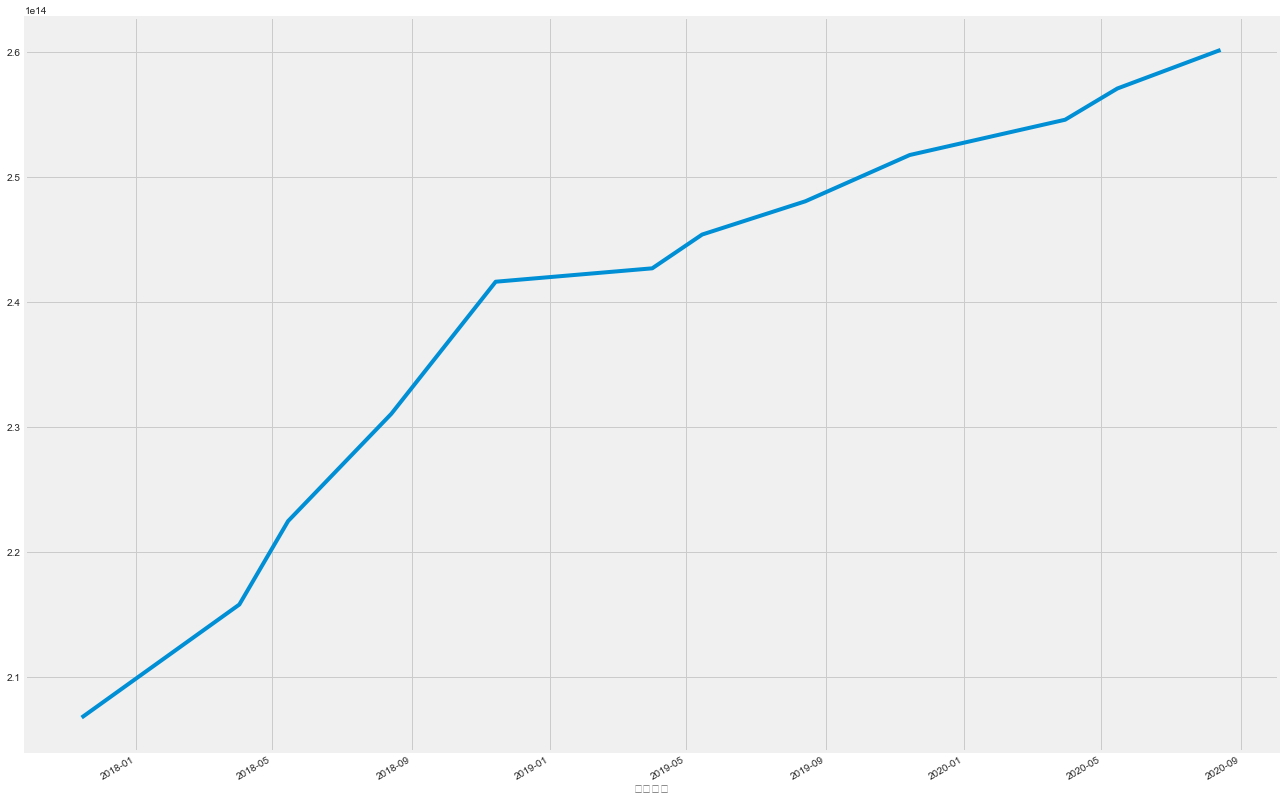

In [136]:
fig = plt.figure(figsize=(20, 15))
ax = fig.subplots()
fs_all_tmp['이익잉여금'].plot(ax=ax)

<AxesSubplot:xlabel='접수일자'>

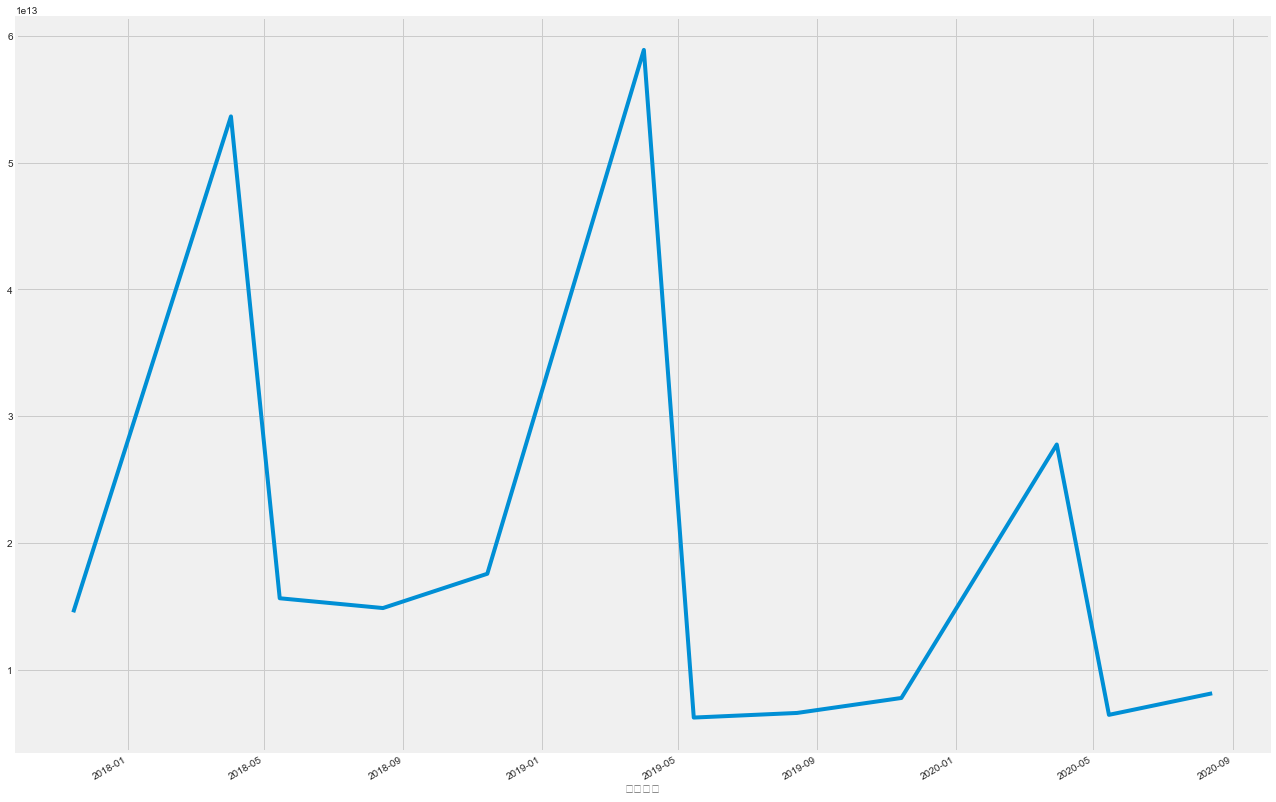

In [137]:
fig = plt.figure(figsize=(20, 15))
ax = fig.subplots()
fs_all_tmp['영업이익'].plot(ax=ax)

<AxesSubplot:xlabel='접수일자'>

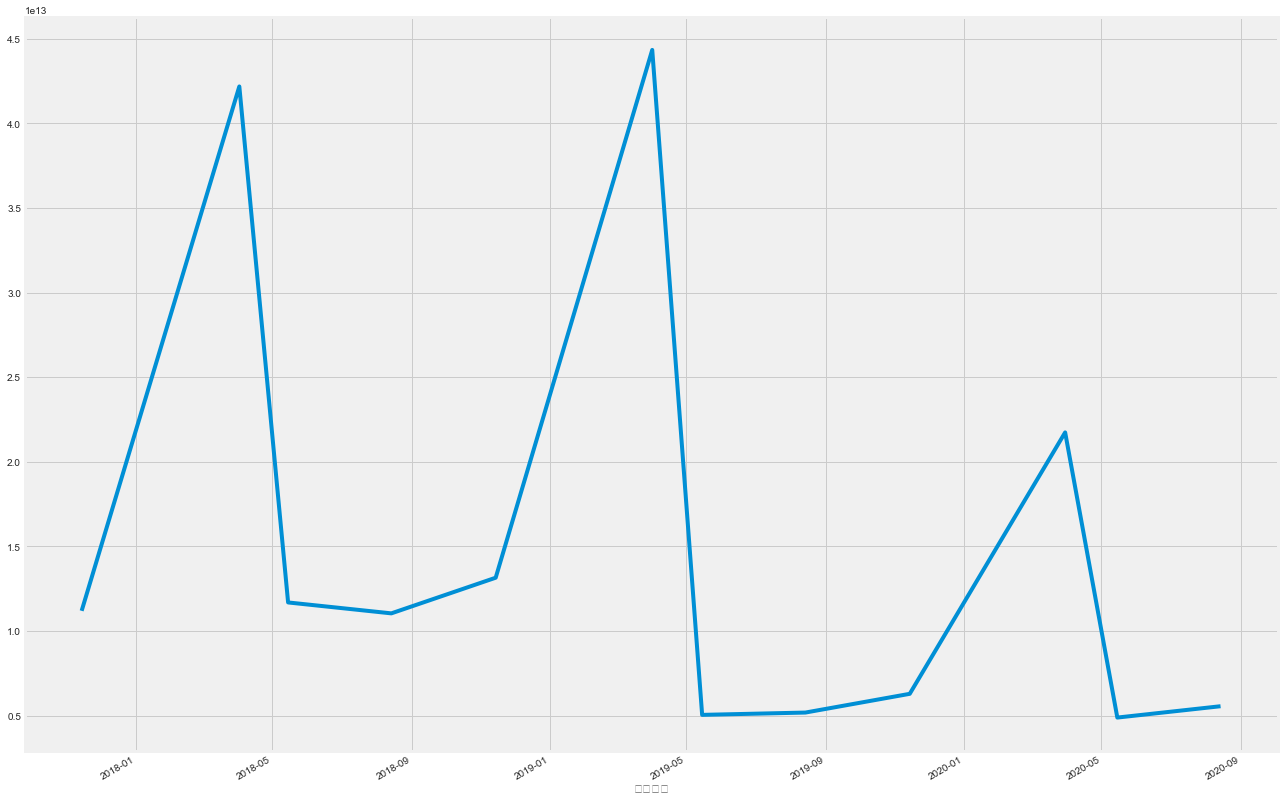

In [138]:
fig = plt.figure(figsize=(20, 15))
ax = fig.subplots()
fs_all_tmp['당기순이익'].plot(ax=ax)

<AxesSubplot:xlabel='접수일자'>

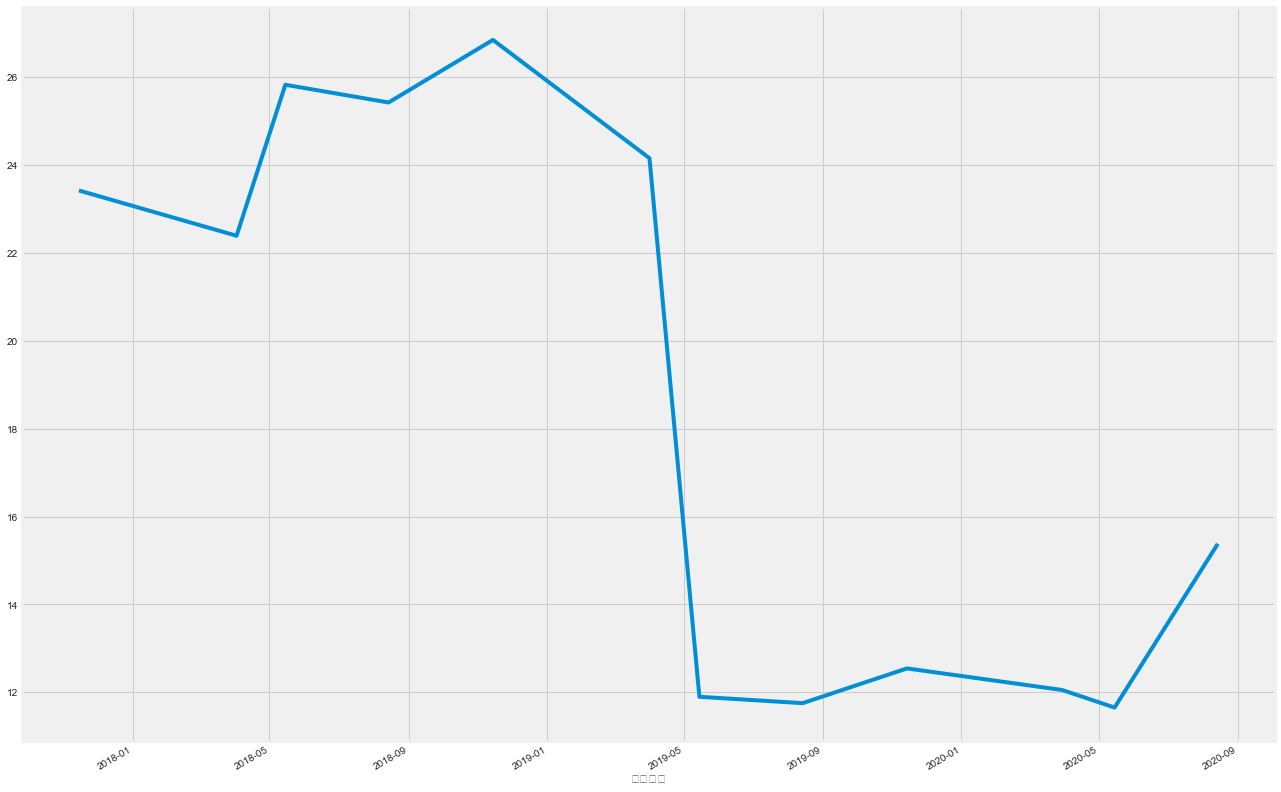

In [139]:
fig = plt.figure(figsize=(20, 15))
ax = fig.subplots()
fs_all_tmp['매출액영업이익률(OPM)'].plot(ax=ax)

In [140]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

samsung_tmp = pd.concat([samsung, fs_all_tmp])
samsung_tmp.rename(columns={'영업이익':'diff1', '당기순이익':'diff2'}, inplace=True)
#samsung_tmp.drop(['접수일자'], axis=1, inplace=True)
samsung_tmp.drop(['기준일'], axis=1, inplace=True)
samsung_tmp.fillna(0, inplace=True)
samsung_tmp.sort_index(inplace=True)
samsung_tmp

,Close,유동자산,비유동자산,자산총계,유동부채,비유동부채,부채총계,이익잉여금,자본총계,자본금,...,유동비율,매출증가율,총자산증가율,순이익증가율,매출액영업이익률(OPM),매출액경상이익률,매출액순이익률(NPM),총자산회전율,ROE,ROA
2000-01-04,6110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-05,5580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-06,5620.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-07,5540.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-10,5770.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-07,82900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-08,88800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-11,91000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-12,90600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


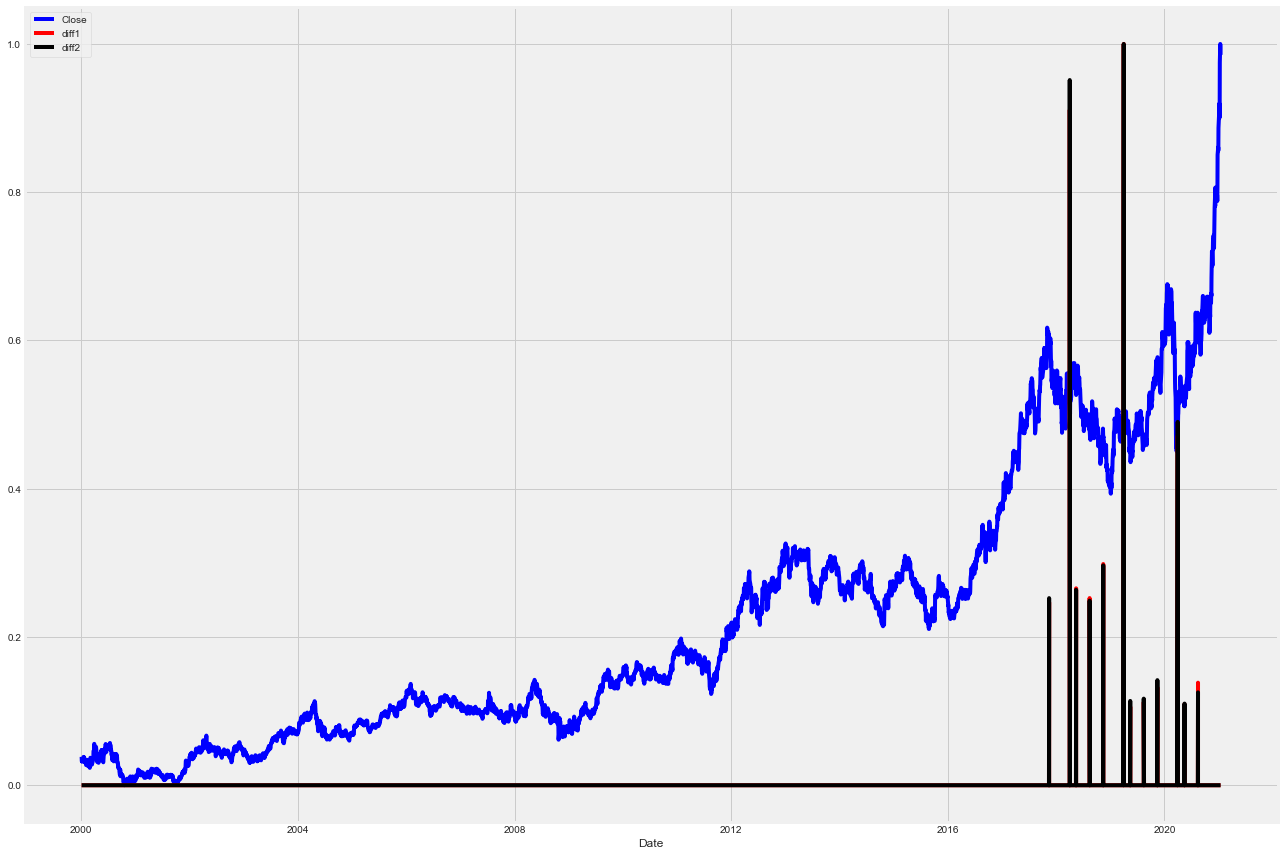

In [141]:
x = samsung_tmp.values
x_scaled = scaler.fit_transform(x)
samsung_tmp_scale = pd.DataFrame(x_scaled, columns=samsung_tmp.columns, index=samsung_tmp.index)
plt.figure(figsize=(20, 15))
plt.xlabel('Date')

orig = samsung_tmp_scale['Close']
plt.plot(orig, color='blue',label='Close')
diff1 = samsung_tmp_scale['diff1']
plt.plot(diff1, color='red', label='diff1')
diff2 = samsung_tmp_scale['diff2']
plt.plot(diff2, color='black', label = 'diff2')
plt.legend(loc='best')
plt.show()

In [ ]:
# PBR, PER 그래프